# imports and reading data

In [76]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
import numpy as np
import os

from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# %%

In [2]:
PATH = os.path.join(os.getcwd(), 'data', 'titanic.csv')

df = pd.read_csv(PATH)

In [3]:

df.drop(inplace=True, columns=["PassengerId",'Name', 'Ticket', 'Cabin'])
df.dropna(inplace=True)


In [4]:
df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "male" else 0)
df["Embarked"] = df["Embarked"].apply(lambda x: 0 if x == "S" else 1 if x == "C" else 2)


In [5]:
# # train test split
# from sklearn.model_selection import train_test_split

# X = df.drop(columns=["Survived"])
# y = df["Survived"]  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df = X_train  

# Rule generatrion

In [6]:
CATEGORICAL_COLUMNS = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
NUMERIC_COLUMNS = ["Age", "Fare"]

In [7]:
# min max scaling
for col in NUMERIC_COLUMNS:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [8]:
def get_support(df, rule):
    df_filtered = df.query(rule)
    return len(df_filtered) / len(df)

def get_effectiveness(df, rule):
    df_filtered = df.query(rule)
    return len(df_filtered[df_filtered["Survived"] == 1]) / len(df_filtered)

In [9]:
def rules_by_categoric_column(df, column):
    rules = []
    for value in df[column].unique():
        rule = f"{column} == {value}"
        df_filtered = df.query(rule)
        target_percentage = df_filtered["Survived"].mean()
        rule_support = len(df_filtered) / len(df)
        
        rules.append({"rule": rule, 
                        "effectiveness": target_percentage, 
                        "support": rule_support})    
    return rules

In [10]:
def rules_by_numeric_column(df, column, num_rules=10):
    rules = []
    for value in np.linspace(df[column].min(), df[column].max(), num_rules+2)[1:-1]:
        rule_by_sign = [f"{column} >= {value}", f"{column} < {value}"]
        for rule in rule_by_sign:
            df_filtered = df.query(rule)
            target_percentage = df_filtered["Survived"].mean()
            rule_support = len(df_filtered) / len(df)

            rules.append({"rule": rule, 
                           "effectiveness": target_percentage, 
                           "support": rule_support})
    return rules

In [11]:
all_rules = []

for col in CATEGORICAL_COLUMNS:
    all_rules.extend(rules_by_categoric_column(df, col))

for col in NUMERIC_COLUMNS:
    all_rules.extend(rules_by_numeric_column(df, col))

In [12]:
df_all_rules = pd.DataFrame(all_rules)
df_all_rules.sort_values("effectiveness", ascending=False, inplace=True)

In [13]:
df_all_rules

,rule,effectiveness,support
51,Fare >= 0.5454545454545454,1.000000,0.004213
55,Fare >= 0.7272727272727273,1.000000,0.004213
59,Fare >= 0.9090909090909092,1.000000,0.004213
57,Fare >= 0.8181818181818182,1.000000,0.004213
53,Fare >= 0.6363636363636364,1.000000,0.004213
...,...,...,...
8,SibSp == 4,0.166667,0.025281
37,Age >= 0.8181818181818182,0.125000,0.011236
16,Parch == 4,0.000000,0.005618
10,SibSp == 5,0.000000,0.007022


In [79]:
def get_new_rule(rules, min_antecedents=1, max_antecedents=5, min_df_size=10):
    num_antecedents = np.random.randint(min_antecedents, max_antecedents+1)
    rule = np.random.choice(rules, num_antecedents, replace=False)
    rule_str =  " and ".join([rule["rule"] for rule in rule])
    
    if len(df.query(rule_str)) < min_df_size:
        return get_new_rule(rules, min_df_size=min_df_size)
    
    support = get_support(df, rule_str)
    effectiveness = get_effectiveness(df, rule_str)
    mass_self = support * effectiveness
    mass_other = support * (1 - effectiveness)
    uncertainty = 1 - mass_self - mass_other
    
    assert uncertainty >= 0
    
    return {"rule": rule_str, 
            "support": support, 
            "effectiveness": effectiveness,
            "mass_self": mass_self,
            "mass_other": mass_other, 
            "uncertainty": uncertainty}

In [65]:
"""
A framework for performing computations in the Dempster-Shafer theory.
"""

from __future__ import print_function
from itertools import chain, combinations
from functools import partial, reduce
from operator import mul
from math import log, fsum, sqrt
from random import random, shuffle, uniform
import sys

try:
    import numpy
    try:
        from scipy.stats import chi2
        from scipy.optimize import fmin_cobyla
    except:
        print('SciPy not found: some features will not work.', file=sys.stderr)
except:
    print('NumPy not found: some features will not work.', file=sys.stderr)


class MassFunction(dict):
    """
    A Dempster-Shafer mass function (basic probability assignment) based on a dictionary.
    
    Both normalized and unnormalized mass functions are supported.
    The underlying frame of discernment is assumed to be discrete.
    
    Hypotheses and their associated mass values can be added/changed/removed using the standard dictionary methods.
    Each hypothesis can be an arbitrary sequence which is automatically converted to a 'frozenset', meaning its elements must be hashable.
    """
    
    def __init__(self, source=None):
        """
        Creates a new mass function.
        
        If 'source' is not None, it is used to initialize the mass function.
        It can either be a dictionary mapping hypotheses to non-negative mass values
        or an iterable containing tuples consisting of a hypothesis and a corresponding mass value.
        """
        if source != None:
            if isinstance(source, dict):
                source = source.items()
            for (h, v) in source:
                self[h] += v
    
    @staticmethod
    def _convert(hypothesis):
        """Convert hypothesis to a 'frozenset' in order to make it hashable."""
        if isinstance(hypothesis, frozenset):
            return hypothesis
        else:
            return frozenset(hypothesis)
    
    @staticmethod
    def gbt(likelihoods, normalization=True, sample_count=None):
        """
        Constructs a mass function using the generalized Bayesian theorem.
        For more information, see Smets. 1993. Belief functions: 
        The disjunctive rule of combination and the generalized Bayesian theorem. International Journal of Approximate Reasoning. 
        
        'likelihoods' specifies the conditional plausibilities for a set of singleton hypotheses.
        It can either be a dictionary mapping singleton hypotheses to plausibilities or an iterable
        containing tuples consisting of a singleton hypothesis and a corresponding plausibility value.
        
        'normalization' determines whether the resulting mass function is normalized, i.e., whether m({}) == 0.
        
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        """
        m = MassFunction()
        if isinstance(likelihoods, dict):
            likelihoods = list(likelihoods.items())
        # filter trivial likelihoods 0 and 1
        ones = [h for (h, l) in likelihoods if l >= 1.0]
        likelihoods = [(h, l) for (h, l) in likelihoods if 0.0 < l < 1.0]
        if sample_count == None:   # deterministic
            def traverse(m, likelihoods, ones, index, hyp, mass):
                if index == len(likelihoods):
                    m[hyp + ones] = mass
                else:
                    traverse(m, likelihoods, ones, index + 1, hyp + [likelihoods[index][0]], mass * likelihoods[index][1])
                    traverse(m, likelihoods, ones, index + 1, hyp, mass * (1.0 - likelihoods[index][1]))
            traverse(m, likelihoods, ones, 0, [], 1.0)
            if normalization:
                m.normalize()
        else:   # Monte-Carlo
            if normalization:
                empty_mass = reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0)
            for _ in range(sample_count):
                rv = [random() for _ in range(len(likelihoods))]
                subtree_mass = 1.0
                hyp = set(ones)
                for k in range(len(likelihoods)):
                    l = likelihoods[k][1]
                    p_t = l * subtree_mass
                    p_f = (1.0 - l) * subtree_mass
                    if normalization and not hyp: # avoid empty hypotheses in the normalized case
                        p_f -= empty_mass
                    if p_t > rv[k] * (p_t + p_f):
                        hyp.add(likelihoods[k][0])
                    else:
                        subtree_mass *= 1 - l # only relevant for the normalized empty case
                m[hyp] += 1.0 / sample_count
        return m
    
    @staticmethod
    def from_bel(bel):
        """
        Creates a mass function from a corresponding belief function.
        
        'bel' is a dictionary mapping hypotheses to belief values (like the dictionary returned by 'bel(None)').
        """
        m = MassFunction()
        for h1 in bel.keys():
            v = fsum([bel[h2] * (-1)**(len(h1 - h2)) for h2 in powerset(h1)])
            if v > 0:
                m[h1] = v
        mass_sum = fsum(m.values())
        if mass_sum < 1.0:
            m[frozenset()] = 1.0 - mass_sum
        return m
    
    @staticmethod
    def from_pl(pl):
        """
        Creates a mass function from a corresponding plausibility function.
        
        'pl' is a dictionary mapping hypotheses to plausibility values (like the dictionary returned by 'pl(None)').
        """
        frame = max(pl.keys(), key=len)
        bel_theta = pl[frame]
        bel = {frozenset(frame - h):bel_theta - v for (h, v) in pl.items()} # follows from bel(-A) = bel(frame) - pl(A)
        return MassFunction.from_bel(bel)
    
    @staticmethod
    def from_q(q):
        """
        Creates a mass function from a corresponding commonality function.
        
        'q' is a dictionary mapping hypotheses to commonality values (like the dictionary returned by 'q(None)').
        """
        m = MassFunction()
        frame = max(q.keys(), key=len)
        for h1 in q.keys():
            v = fsum([q[h1 | h2] * (-1)**(len(h2 - h1)) for h2 in powerset(frame - h1)])
            if v > 0:
                m[h1] = v
        mass_sum = fsum(m.values())
        if mass_sum < 1.0:
            m[frozenset()] = 1.0 - mass_sum
        return m
    
    def __missing__(self, key):
        """Return 0 mass for hypotheses that are not contained."""
        return 0.0
    
    def __copy__(self):
        c = MassFunction()
        for k, v in self.items():
            c[k] = v
        return c
    
    def copy(self):
        """Creates a shallow copy of the mass function."""
        return self.__copy__()
    
    def __contains__(self, hypothesis):
        return dict.__contains__(self, MassFunction._convert(hypothesis))
    
    def __getitem__(self, hypothesis):
        return dict.__getitem__(self, MassFunction._convert(hypothesis))
    
    def __setitem__(self, hypothesis, value):
        """
        Adds or updates the mass value of a hypothesis.
        
        'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        In case of a negative mass value, a ValueError is raised.
        """
        if value < 0.0:
            raise ValueError("mass value is negative: %f" % value)
        dict.__setitem__(self, MassFunction._convert(hypothesis), value)
    
    def __delitem__(self, hypothesis):
        return dict.__delitem__(self, MassFunction._convert(hypothesis))
    
    def frame(self):
        """
        Returns the frame of discernment of the mass function as a 'frozenset'.
        
        The frame of discernment is the union of all contained hypotheses.
        In case the mass function does not contain any hypotheses, an empty set is returned.
        """
        if not self:
            return frozenset()
        else:
            return frozenset.union(*self.keys())
    
    def singletons(self):
        """
        Returns the set of all singleton hypotheses.
        
        Like 'frame()', except that each singleton is wrapped in a frozenset
        and can thus be directly passed to methods like 'bel()'.
        """
        return {frozenset((s,)) for s in self.frame()}
    
    def focal(self):
        """
        Returns the set of all focal hypotheses.
        
        A focal hypothesis has a mass value greater than 0.
        """
        return {h for (h, v) in self.items() if v > 0}
    
    def core(self, *mass_functions):
        """
        Returns the core of one or more mass functions as a 'frozenset'.
        
        The core of a single mass function is the union of all its focal hypotheses.
        In case a mass function does not contain any focal hypotheses, its core is an empty set.
        If multiple mass functions are given, their combined core (intersection of all single cores) is returned.
        """
        if mass_functions:
            return frozenset.intersection(self.core(), *[m.core() for m in mass_functions])
        else:
            focal = self.focal()
            if not focal:
                return frozenset()
            else:
                return frozenset.union(*focal)
    
    def all(self):
        """Returns an iterator over all subsets of the frame of discernment, including the empty set."""
        return powerset(self.frame())
    
    def bel(self, hypothesis=None):
        """
        Computes either the belief of 'hypothesis' or the entire belief function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective belief values is returned.
        Otherwise, the belief of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.bel(h) for h in powerset(self.core())}
        else:
            hypothesis = MassFunction._convert(hypothesis)
            if not hypothesis:
                return 0.0
            else:
                return fsum([v for (h, v) in self.items() if h and hypothesis.issuperset(h)])
    
    def pl(self, hypothesis=None):
        """
        Computes either the plausibility of 'hypothesis' or the entire plausibility function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective plausibility values is returned.
        Otherwise, the plausibility of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.pl(h) for h in powerset(self.core())}
        else:
            hypothesis = MassFunction._convert(hypothesis)
            if not hypothesis:
                return 0.0
            else:
                return fsum([v for (h, v) in self.items() if hypothesis & h])
    
    def q(self, hypothesis=None):
        """
        Computes either the commonality of 'hypothesis' or the entire commonality function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective commonality values is returned.
        Otherwise, the commonality of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.q(h) for h in powerset(self.core())}
        else:
            if not hypothesis:
                return 1.0
            else:
                return fsum([v for (h, v) in self.items() if h.issuperset(hypothesis)])
    
    def __and__(self, mass_function):
        """Shorthand for 'combine_conjunctive(mass_function)'."""
        return self.combine_conjunctive(mass_function)
    
    def __or__(self, mass_function):
        """Shorthand for 'combine_disjunctive(mass_function)'."""
        return self.combine_disjunctive(mass_function)
    
    def __str__(self):
        hyp = sorted([(v, h) for (h, v) in self.items()], reverse=True)
        return "{" + "; ".join([str(set(h)) + ":" + str(v) for (v, h) in hyp]) + "}"
    
    def __mul__(self, scalar):
        if not isinstance(scalar, float):
            raise TypeError('Can only multiply by a float value.')
        m = MassFunction()
        for (h, v) in self.items():
            m[h] = v * scalar
        return m
    
    def __rmul__(self, scalar):
        return self.__mul__(scalar)
    
    def __add__(self, m):
        if not isinstance(m, MassFunction):
            raise TypeError('Can only add two mass functions.')
        result = self.copy()
        for (h, v) in m.items():
            result[h] += v
        return result
    
    def weight_function(self):
        """
        Computes the weight function corresponding to this mass function.
        """
        weights = dict()
        q = self.q()
        theta = self.frame()
        for h in powerset(theta):
            if len(h) < len(theta): # weight is undefined for theta
                sets = [h | c for c in powerset(theta - h)]
                q_even = reduce(mul, [q[h2] for h2 in sets if len(h2) % 2 == 0], 1.0)
                q_odd = reduce(mul, [q[h2] for h2 in sets if len(h2) % 2 == 1], 1.0)
                if len(h) % 2 == 0:
                    weights[h] = q_odd / q_even
                else:
                    weights[h] = q_even / q_odd
        return weights
    
    def combine_conjunctive(self, mass_function, normalization=True, sample_count=None, importance_sampling=False):
        """
        Conjunctively combines the mass function with another mass function and returns the combination as a new mass function.
        
        The other mass function is assumed to be defined over the same frame of discernment.
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions that are iteratively combined.
        
        If the mass functions are flatly contracting or if one of the mass functions is empty, an empty mass function is returned.
        
        'normalization' determines whether the resulting mass function is normalized (default is True).
         
        If 'sample_count' is not None, the true combination is approximated using the specified number of samples.
        In this case, 'importance_sampling' determines the method of approximation (only if normalization=True, otherwise 'importance_sampling' is ignored).
        The default method (importance_sampling=False) independently generates samples from both mass functions and computes their intersections.
        If importance_sampling=True, importance sampling is used to avoid empty intersections, which leads to a lower approximation error but is also slower.
        This method should be used if there is significant evidential conflict between the mass functions.
        """
        return self._combine(mass_function, rule=lambda s1, s2: s1 & s2, normalization=normalization, sample_count=sample_count, importance_sampling=importance_sampling)
    
    def combine_disjunctive(self, mass_function, sample_count=None):
        """
        Disjunctively combines the mass function with another mass function and returns the combination as a new mass function.
        
        The other mass function is assumed to be defined over the same frame of discernment.
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions that are iteratively combined.
        
        If 'sample_count' is not None, the true combination is approximated using the specified number of samples.
        """
        return self._combine(mass_function, rule=lambda s1, s2: s1 | s2, normalization=False, sample_count=sample_count, importance_sampling=False)
    
    def combine_cautious(self, mass_function):
        """
        Combines the mass function with another mass function using the cautious rule and returns the combination as a new mass function.
        
        For more details, see:
        T. Denoeux (2008), "Conjunctive and disjunctive combination of belief functions induced by nondistinct bodies of evidence",
        Artificial Intelligence 172, 234-264.
        """
        w1 = self.weight_function()
        w2 = mass_function.weight_function()
        w_min = {h:min(w1[h], w2[h]) for h in w1}
        theta = self.frame()
        m = MassFunction({theta:1.0})
        for h, w in w_min.items():
            m_simple = MassFunction({theta:w, h:1.0 - w})
            m = m.combine_conjunctive(m_simple, normalization=False)
        return m
    
    def _combine(self, mass_function, rule, normalization, sample_count, importance_sampling):
        """Helper method for combining two or more mass functions."""
        combined = self
        if isinstance(mass_function, MassFunction):
            mass_function = [mass_function] # wrap single mass function
        for m in mass_function:
            if not isinstance(m, MassFunction):
                raise TypeError("expected type MassFunction but got %s; make sure to use keyword arguments for anything other than mass functions" % type(m))
            if sample_count == None:
                combined = combined._combine_deterministic(m, rule)
            else:
                if importance_sampling and normalization:
                    combined = combined._combine_importance_sampling(m, sample_count)
                else:
                    combined = combined._combine_direct_sampling(m, rule, sample_count)
        if normalization:
            return combined.normalize()
        else:
            return combined
    
    def _combine_deterministic(self, mass_function, rule):
        """Helper method for deterministically combining two mass functions."""
        combined = MassFunction()
        for (h1, v1) in self.items():
            for (h2, v2) in mass_function.items():
                combined[rule(h1, h2)] += v1 * v2
        return combined
    
    def _combine_direct_sampling(self, mass_function, rule, sample_count):
        """Helper method for approximatively combining two mass functions using direct sampling."""
        combined = MassFunction()
        samples1 = self.sample(sample_count)
        samples2 = mass_function.sample(sample_count)
        for i in range(sample_count):
            combined[rule(samples1[i], samples2[i])] += 1.0 / sample_count
        return combined
    
    def _combine_importance_sampling(self, mass_function, sample_count):
        """Helper method for approximatively combining two mass functions using importance sampling."""
        combined = MassFunction()
        for (s1, n) in self.sample(sample_count, as_dict=True).items():
            weight = mass_function.pl(s1)
            for s2 in mass_function.condition(s1).sample(n):
                combined[s2] += weight
        return combined
    
    def combine_gbt(self, likelihoods, normalization=True, sample_count=None, importance_sampling=True):
        """
        Conjunctively combines the mass function with a mass function obtained from a sequence of
        likelihoods via the generalized Bayesian theorem and returns the combination as a new mass function.
        
        Equivalent to 'combine_conjunctive(MassFunction.gbt(likelihoods))'.
        By ignoring incompatible likelihoods, it is generally faster than the former
        method and yields a better Monte-Carlo approximation in case of normalization.
        
        'likelihoods' specifies the conditional plausibilities for a set of singleton hypotheses.
        It can either be a dictionary mapping singleton hypotheses to plausibilities or an iterable
        containing tuples consisting of a singleton hypothesis and a corresponding plausibility value.
        
        All arguments except for 'likelihoods' must be specified as keyword arguments.
        'normalization' determines whether the resulting mass function is normalized, i.e., whether m({}) == 0.
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        See 'combine_conjunctive' for details on the effect of setting 'importance_sampling'.
        """
        core = self.core() # restrict to generally compatible likelihoods
        if isinstance(likelihoods, dict):
            likelihoods = list(likelihoods.items())
        likelihoods = [l for l in likelihoods if l[1] > 0 and l[0] in core]
        if sample_count == None: # deterministic
            return self.combine_conjunctive(MassFunction.gbt(likelihoods), normalization=normalization)
        else: # Monte-Carlo
            if not normalization: # only use importance sampling in case of normalization
                importance_sampling = False
            combined = MassFunction()
            for s, n in self.sample(sample_count, as_dict=True).items():
                if importance_sampling:
                    compatible_likelihoods = [l for l in likelihoods if l[0] in s]
                    weight = 1.0 - reduce(mul, [1.0 - l[1] for l in compatible_likelihoods], 1.0)
                else:
                    compatible_likelihoods = likelihoods
                if not compatible_likelihoods:
                    continue
                if normalization:
                    empty_mass = reduce(mul, [1.0 - l[1] for l in compatible_likelihoods], 1.0)
                for _ in range(n):
                    rv = [random() for _ in range(len(compatible_likelihoods))]
                    subtree_mass = 1.0
                    hyp = set()
                    for k in range(len(compatible_likelihoods)):
                        l = compatible_likelihoods[k][1]
                        norm = 1.0 if hyp or not normalization else 1.0 - empty_mass / subtree_mass
                        if l / norm > rv[k]:
                            hyp.add(compatible_likelihoods[k][0])
                        else:
                            subtree_mass *= 1.0 - l   # only relevant for negative case
                    if importance_sampling:
                        combined[hyp] += weight
                    else:
                        combined[hyp & s] += 1.0
            if normalization:
                return combined.normalize()
            else:
                return combined
    
    def condition(self, hypothesis, normalization=True):
        """
        Conditions the mass function with 'hypothesis'.
        
        'normalization' determines whether the resulting conjunctive combination is normalized (must be specified as a keyword argument).
        
        Shorthand for self.combine_conjunctive(MassFunction({hypothesis:1.0}), normalization).
        """
        m = MassFunction({MassFunction._convert(hypothesis):1.0})
        return self.combine_conjunctive(m, normalization=normalization)
    
    def conflict(self, mass_function, sample_count=None):
        """
        Calculates the weight of conflict between two or more mass functions.
        
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions.
        
        The weight of conflict is computed as the (natural) logarithm of the normalization constant in Dempster's rule of combination.
        Returns infinity in case the mass functions are flatly contradicting.
        """
        # compute full conjunctive combination (could be more efficient)
        m = self.combine_conjunctive(mass_function, normalization=False, sample_count=sample_count)
        empty = m[frozenset()]
        m_sum = fsum(m.values())
        diff = m_sum - empty
        if diff == 0.0:
            return float('inf')
        else:
            return -log(diff)
    
    def normalize(self):
        """
        Normalizes the mass function in-place.
        
        Sets the mass value of the empty set to 0 and scales all other values such that their sum equals 1.
        For convenience, the method returns 'self'.
        """
        if frozenset() in self:
            del self[frozenset()]
        mass_sum = fsum(self.values())
        if mass_sum != 1.0:
            for (h, v) in self.items():
                self[h] = v / mass_sum
        return self
    
    def prune(self):
        """
        Removes all non-focal (0 mass) hypotheses in-place.
        
        For convenience, the method returns 'self'.
        """ 
        remove = [h for (h, v) in self.items() if v == 0.0]
        for h in remove:
            del self[h]
        return self
    
    def markov(self, transition_model, sample_count=None):
        """
        Computes the mass function induced by a prior belief (self) and a transition model.
        
        The transition model expresses a joint belief over the frame of this mass function and a new frame.
        The belief over the frame of this mass function is implicitly assumed to be vacuous.
        The transition model is a function returning the conditional belief over the new frame (as a mass function
        if sample_count=None) while taking a singleton hypothesis of the current frame as input.
        The disjunctive rule of combination is then used to construct the mass function over the new frame.
        
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        In this case, 'transition_model' is expected to take a second argument stating how many samples from the corresponding conditional mass function should be returned.
        The return value in this case is expected to be an iterable over sampled hypotheses from the new frame.
         
        This method can be used to implement the prediction step for estimation in a hidden Markov process (hence the name).
        Under this interpretation, the transition model expresses the mass distribution over successor states given the current state.
        """
        updated = MassFunction()
        if sample_count == None: # deterministic
            for k, v in self.items():
                predicted = None
                for e in k:
                    if predicted == None:
                        predicted = transition_model(e)
                    else:
                        predicted |= transition_model(e)
                for kp, vp in predicted.items():
                    updated[kp] += v * vp
        else: # Monte-Carlo
            for s, n in self.sample(sample_count, as_dict=True).items():
                unions = [[] for _ in range(n)]
                for e in s:
                    ts = transition_model(e, n)
                    for i, t in enumerate(ts):
                        unions[i].extend(t)
                for u in unions:
                    updated[u] += 1.0 / sample_count
        return updated
    
    def map(self, function):
        """
        Maps each hypothesis to a new hypothesis using 'function' and returns the new mass function.
        
        'function' is a function taking a hypothesis as its only input and returning a new hypothesis
        (i.e., a sequence that can be converted to a 'frozenset').
        
        Here are some example use cases:
        
        1. Vacuous extension to a multi-dimensional frame of discernment (m is defined over
        the frame A while the new mass function is defined over the Cartesian product AxB):
            
            B = {'x', 'y', 'z'}
            m.map(lambda h: itertools.product(h, B))
        
        2. Projection to a lower dimensional frame (m is defined over AxBxC such that each hypothesis is
        a set of tuples where each tuple consists of 3 elements; the new mass function is defined over BxC):
        
            m.map(lambda h: (t[1:] for t in h))
        """
        m = MassFunction()
        for (h, v) in self.items():
            m[self._convert(function(h))] += v
        return m
    
    def pignistic(self):
        """Computes the pignistic transformation and returns it as a new mass function consisting only of singletons."""
        p = MassFunction()
        for (h, v) in self.items():
            if v > 0.0:
                size = float(len(h))
                for s in h:
                    p[(s,)] += v / size
        return p.normalize()
    
    def local_conflict(self):
        """
        Computes the local conflict measure.
        
        For more information, see Pal et al. 1993. Uncertainty measures for evidential reasoning II:
        A new measure of total uncertainty. International Journal of Approximate Reasoning.
        
        Only works for normalized mass functions.
        If the mass function is unnormalized, the method returns float('nan')
        
        In case the mass function is a probability function (containing only singleton hypotheses),
        it reduces to the classical entropy measure.
        """
        if self[frozenset()] > 0.0:
            return float('nan')
        c = 0.0
        for (h, v) in self.items():
            if v > 0.0:
                c += v * log(len(h) / v, 2)
        return c
    
    def hartley_measure(self):
        """
        Computes the Hartley-like measure in order to quantify the amount of imprecision.
        
        For more information, see:
        G. J. Klir (1999), "Uncertainty and information measures for imprecise probabilities: An overview",
        International Symposium on Imprecise Probabilities and Their Applications.
        """
        return fsum([v * log(len(h), 2) for h, v in self.items()])
    
    def norm(self, m, p=2):
        """
        Computes the p-norm between two mass functions (default is p=2).
        
        Both mass functions are treated as vectors of mass values.
        """
        d = fsum([(v - m[h])**p for (h, v) in self.items()])
        for (h, v) in m.items():
            if h not in self:
                d += v**p
        return d**(1.0 / p)
    
    def is_compatible(self, m):
        """
        Checks whether another mass function is compatible with this one.
        
        Compatibility means that the mass value of each hypothesis in 'm' is less than
        or equal to the corresponding plausibility given by this mass function.
        """
        return all([self.pl(h) >= v for (h, v) in m.items()])
    
    def sample(self, n, quantization=True, as_dict=False):
        """
        Returns n random samples from the mass distribution.
        
        Hypotheses are drawn with a probability proportional to their mass values (with replacement).
         
        If 'quantization' is True (default), the method performs a quantization of the mass values.
        This means the frequency of a hypothesis h in the sample set is at least int(self[h] * n / t) where t is the sum of all mass values.
        The remaining sample slots (if any) are filled up according to the remainders of the fractions computed in the first step.
        
        The parameter 'as_dict' determines the type of the returned value.
        If 'as_dict' is False (default), a list of length n is returned.
        Otherwise, the result is a dictionary specifying the number of samples for each hypothesis.
        """
        if not isinstance(n, int):
            raise TypeError("n must be int")
        samples = {h:0 for h in self} if as_dict else []
        mass_sum = fsum(self.values())
        if quantization:
            remainders = []
            remaining_sample_count = n
            for (h, v) in self.items():
                fraction = n * v / mass_sum
                quotient = int(fraction)
                if quotient > 0:
                    if as_dict:
                        samples[h] = quotient
                    else:
                        samples.extend([h] * quotient)
                remainders.append((h, fraction - quotient))
                remaining_sample_count -= quotient
            remainders.sort(reverse=True, key=lambda hv: hv[1])
            for h, _ in remainders[:remaining_sample_count]:
                if as_dict:
                    samples[h] += 1
                else:
                    samples.append(h)
        else:
            rv = [uniform(0.0, mass_sum) for _ in range(n)]
            hypotheses = sorted(self.items(), reverse=True, key=lambda hv: hv[1])
            for i in range(n):
                mass = 0.0
                for (h, v) in hypotheses:
                    mass += v
                    if mass >= rv[i]:
                        if as_dict:
                            samples[h] += 1
                        else:
                            samples.append(h)
                        break
        if not as_dict:
            shuffle(samples)
        return samples
    
    def is_probabilistic(self):
        """
        Checks whether the mass function is a probability function.
        
        Returns True if and only if all hypotheses are singletons (normalization is ignored). 
        """
        return all([len(h) == 1 for h in self.keys()])
    
    def sample_probability_distributions(self, n):
        """
        Randomly generates n compatible probability distributions from the mass function.
        
        The result is a list of n independently sampled probability distributions expressed as mass functions.
        This can be useful for estimating various statistical measures like the minimum or maximum entropy consistent with the mass distribution.
        """
        samples = [MassFunction() for _ in range(n)]
        for i in range(n):
            for (h, v) in self.items():
                if len(h) == 1:
                    samples[i][h] += v
                else:
                    rv = [random() for _ in range(len(h))]
                    total = fsum(rv)
                    for k, s in enumerate(h):
                        samples[i][{s}] += rv[k] * v / total
        return samples
    
    def max_bel(self):
        """
        Returns the singleton with the highest belief.
        
        In case there are multiple singletons with maximum belief, only one of them is returned.
        Returns None, if the mass function does not contain any hypotheses.
        """
        return self._max_singleton(self.bel)
    
    def max_pl(self):
        """
        Returns the singleton with the highest plausibility.
        
        In case there are multiple singletons with maximum plausibility, only one of them is returned.
        Returns None, if the mass function does not contain any hypotheses.
        """
        return self._max_singleton(self.pl)
    
    def _max_singleton(self, f):
        st = self.singletons()
        if st:
            value_list = [(f(s), s) for s in st]
            shuffle(value_list)
            return max(value_list)[1]
        else:
            return None
    
    def to_dict(self):
        """Convert a mass function only consisting of singletons to a dictionary by removing each enclosing frozenset."""
        if not self.is_probabilistic():
            raise Exception('mass function must only contain singletons')
        return {tuple(h)[0]:v for h, v in self.items()}
    
    @staticmethod
    def from_dict(d):
        """Convert a dictionary to a mass function by enclosing each key with a frozenset."""
        if isinstance(d, MassFunction):
            return d
        else:
            return MassFunction({frozenset((h,)):v for h, v in d.items()})
    
    @staticmethod
    def from_possibility(poss):
        """
        Constructs a consonant mass function from a possibility distribution.
                
        For more information, see:
        D. Dubois, H. Prade (1982), "On several representations of an uncertainty body of evidence",
        Fuzzy Information and Decision Processes, 167-181.
        """
        if isinstance(poss, MassFunction):
            poss = poss.to_dict() # remove enclosing sets
        H, P = zip(*sorted(poss.items(), key=lambda e: e[1], reverse=True)) # sort possibility values in descending order
        m = MassFunction()
        m[H] = P[-1]
        for i in range(len(H) - 1):
            m[H[:i + 1]] = P[i] - P[i + 1]
        return m
    
    @staticmethod
    def pignistic_inverse(p):
        """
        Constructs a consonant mass function from a pignistic probability distribution by applying the inverse pignistic transformation.
        
        For more information, see:
        D. Dubois, H. Prade, P. Smets (2008), "A definition of subjective possibility",
        International Journal of Approximate Reasoning 48 (2), 352-364.
        """
        p = MassFunction.from_dict(p)
        poss = MassFunction({h1:fsum([min(p[h1], p[h2]) for h2 in p.keys()]) for h1 in p.keys()})
        return MassFunction.from_possibility(poss)
    
    @staticmethod
    def _to_array_index(hypothesis, frame):
        """Map a hypothesis to an array index given a frame of discernment."""
        index = 0
        for i, s in enumerate(frame):
            if s in hypothesis:
                index += 2**i
        return index
    
    @staticmethod
    def _from_array_index(index, frame):
        """Map an array index to a hypothesis given a frame of discernment."""
        hypothesis = set()
        for i, s in enumerate(frame):
            if 2**i & index:
                hypothesis.add(s)
        return frozenset(hypothesis)
    
    def to_array(self, frame):
        """
        Convert the mass function to a NumPy array.
        
        Hypotheses are mapped to array indices using '_to_array_index'.
        The resulting array has 2^n entries where n is the size of the frame of discernment.
        """
        a = numpy.zeros(2**len(frame))
        for h, v in self.items():
            a[MassFunction._to_array_index(h, frame)] = v
        return a
    
    @staticmethod
    def from_array(a, frame):
        """
        Convert a NumPy array to a mass function given a frame of discernment.
        
        Array indices are mapped to hypotheses using '_from_array_index'.
        """
        m = MassFunction()
        for i, v in enumerate(a):
            if v > 0.0:
                m[MassFunction._from_array_index(i, frame)] = v
        return m
    
    @staticmethod
    def _confidence_intervals(histogram, alpha):
        """Compute Goodman confidence intervals."""
        p_lower = {}
        p_upper = {}
        a = chi2.ppf(1. - alpha / len(histogram), 1)
        n = float(sum(histogram.values()))
        for h, n_h in histogram.items():
            delta_h = a * (a + 4. * n_h * (n - n_h) / n)
            p_lower[h] = (a + 2. * n_h - sqrt(delta_h)) / (2. * (n + a))
            p_upper[h] = (a + 2. * n_h + sqrt(delta_h)) / (2. * (n + a))
        return p_lower, p_upper
    
    @staticmethod
    def from_samples(histogram, method='idm', alpha=0.05, s=1.0):
        """
        Generate a mass function from an empirical probability distribution that was obtained from a limited number of samples.
        This makes the expected deviation of the empirical distribution from the true distribution explicit.
        
        'histogram' represents the empirical distribution. It is a dictionary mapping each possible event to the respective
        number of observations (represented as integers).
        
        'method' determines the algorithm used for generating the mass function.
        Except for method 'bayesian', all algorithms are based on the idea that the true probabilities lie within confidence intervals
        represented by the mass function with confidence level 1 - 'alpha'.
        
        The following modes are supported:
        
        'idm': Imprecise Dirichlet model. A small amount of mass (controlled by 's') is assigned to the entire frame.
        For more information on 'idm', see:
        P. Walley (1996), "Inferences from multinomial data: learning about a bag of marbles",
        Journal of the Royal Statistical Society. Series B (Methodological), 3-57.
        
        'maxbel': Maximize the total belief by solving a linear program. (Attention: this becomes very computationally expensive
        for larger numbers of events.)
        
        'maxbel-ordered': Similar to 'maxbel' except that the events are assumed to have a natural order (e.g., intervals), in which case
        the mass function can be computed analytically and thus much faster.
        
        For more information on 'maxbel' and 'maxbel-ordered', see:
        T. Denoeux (2006), "Constructing belief functions from sample data using multinomial confidence regions",
        International Journal of Approximate Reasoning 42, 228-252.
        
        'mcd': Compute the least committed consonant mass function whose pignistic transformation lies within the confidence interval
        induced by 'alpha'. Like 'maxbel', it is based on solving a linear program and quickly becomes computationally expensive.
        
        'mcd-approximate': An approximation of 'mcd' that can be computed much more efficiently.
        
        For more information on these two methods, see:
        A. Aregui, T. Denoeux (2008), "Constructing consonant belief functions from sample data using confidence sets of pignistic probabilities",
        International Journal of Approximate Reasoning 49, 575-594.
        
        'bayesian': Construct a Bayesian mass function based on the relative frequencies. In addition, additive smoothing is applied (controlled by 's'). 
        
        In case the sample number is 0, returns a vacuous mass function (or uniform distribution for 'bayesian').
        
        (Requires SciPy for computing confidence intervals and solving linear programs.)
        """
        if not isinstance(histogram, dict):
            raise TypeError('histogram must be of type dict')
        for v in histogram.values():
            if not isinstance(v, int):
                raise TypeError('all histogram values must be of type int')
        if not histogram:
            return MassFunction()
        if sum(histogram.values()) == 0: # return vacuous/uniform belief if there are no samples
            vac = MassFunction({tuple(histogram.keys()):1})
            if method == 'bayesian':
                return vac.pignistic()
            else:
                return vac
        if method == 'bayesian':
            return MassFunction({(h,):v + s for h, v in histogram.items()}).normalize()
        elif method == 'idm':
            return MassFunction._from_samples_idm(histogram, s)
        elif method == 'maxbel':
            return MassFunction._from_samples_maxbel(histogram, alpha)
        elif method == 'maxbel-ordered':
            return MassFunction._from_samples_maxbel(histogram, alpha, ordered=True)
        elif method == 'mcd':
            return MassFunction._from_samples_mcd(histogram, alpha)
        elif method == 'mcd-approximate':
            return MassFunction._from_samples_mcd(histogram, alpha, approximate=True)
        raise ValueError('unknown method: %s' % method)
    
    @staticmethod
    def _from_samples_idm(histogram, s):
        """
        Reference:
        P. Walley (1996), "Inferences from multinomial data: learning about a bag of marbles",
        Journal of the Royal Statistical Society. Series B (Methodological), 3-57.
        """
        total = sum(histogram.values())
        m = MassFunction()
        for h, c in histogram.items():
            m[(h,)] = float(c) / (total + s)
        m[MassFunction._convert(histogram.keys())] = float(s) / (total + s)
        return m
    
    @staticmethod
    def _from_samples_maxbel(histogram, alpha, ordered=False):
        """
        Reference:
        T. Denoeux (2006), "Constructing belief functions from sample data using multinomial confidence regions",
        International Journal of Approximate Reasoning 42, 228-252.
        """
        p_lower, p_upper = MassFunction._confidence_intervals(histogram, alpha)
        def p_lower_set(hs):
            l = u = 0
            for h in H:
                if h in hs:
                    l += p_lower[h]
                else:
                    u += p_upper[h]
            return max(l, 1 - u)
        if ordered:
            H = sorted(histogram.keys())
            m = MassFunction()
            for i1, h1 in enumerate(H):
                m[(h1,)] = p_lower[h1]
                for i2, h2 in enumerate(H[i1 + 1:]):
                    i2 += i1 + 1
                    if i2 == i1 + 1:
                        v = p_lower_set(H[i1:i2 + 1]) - p_lower[h1] - p_lower[h2]
                    else:
                        v = p_lower_set(H[i1:i2 + 1]) - p_lower_set(H[i1 + 1:i2 + 1]) - p_lower_set(H[i1:i2]) + p_lower_set(H[i1 + 1:i2])
                    if v > 0:
                        m[H[i1:i2 + 1]] = v
            return m
        else:
            H = list(histogram.keys())
            L = 2**len(H)
            initial = numpy.zeros(L)
            cons = []
            singletons = lambda index: [i for i in range(len(H)) if 2**i & index]
            # constraint (24)
            bel = lambda index, m: fsum(m[sum([2**i for i in h_ind])] for h_ind in powerset(singletons(index)))
            c24 = lambda m, i: p_lower_set(MassFunction._from_array_index(i, H)) - bel(i, m)
            for i in range(L):
                cons.append(partial(c24, i=i))
            # constraint (25)
            cons.append(lambda m: m.sum() - 1.0)
            cons.append(lambda m: 1.0 - m.sum())
            # constraint (26)
            for i in range(L):
                cons.append(partial(lambda m, i_s: m[i_s], i_s=i))
            f = lambda m: -1 * 2**len(H) * fsum([m[i] * 2**(-len(singletons(i))) for i in range(L)])
            m_optimal = fmin_cobyla(f, initial, cons, disp=0)
            return MassFunction.from_array(m_optimal, H)
        
    @staticmethod
    def _from_samples_mcd(histogram, alpha, approximate=False):
        """
        Reference:
        A. Aregui, T. Denoeux (2008), "Constructing consonant belief functions from sample data using confidence
        sets of pignistic probabilities", International Journal of Approximate Reasoning 49, 575-594.
        """
        p_lower, p_upper = MassFunction._confidence_intervals(histogram, alpha)
        H = list(histogram.keys())
        if approximate:
            # approximate possibility distribution
            poss = {h1:min(1, fsum([min(p_upper[h1], p_upper[h2]) for h2 in H])) for h1 in H}
        else:
            # optimal possibility distribution (based on linear programming)
            poss = {h:0. for h in H}
            for k, h_k in enumerate(H):
                S_k = {l for l in range(len(H)) if p_lower[H[l]] >= p_upper[h_k]}
                S_k.add(k)
                I_k = {l for l in range(len(H)) if p_upper[H[l]] < p_lower[h_k]}
                P_k = set(range(len(H))).difference(S_k.union(I_k))
                for A in powerset(P_k):
                    G = S_k.union(A)
                    G_c = set(range(len(H))).difference(G)
                    cons = []
                    # constraint (26)
                    for i, h in enumerate(H):
                        cons.append(partial(lambda p, i_s, p_s: p[i_s] - p_s, i_s=i, p_s=p_lower[h])) # lower bound
                        cons.append(partial(lambda p, i_s, p_s: p_s - p[i_s], i_s=i, p_s=p_upper[h])) # upper bound
                    # constraint (27)
                    cons.append(lambda p: 1. - sum(p))
                    cons.append(lambda p: sum(p) - 1.)
                    # constraint (30)
                    for i in G:
                        cons.append(partial(lambda p, i_s: p[i_s] - p[k], i_s=i))
                    # constraint (31)
                    for i in G_c:
                        cons.append(partial(lambda p, i_s: p[k] - p[i_s], i_s=i))
                    initial = [1.0 / len(H)] * len(H)
                    f = lambda p: -(fsum([p[i] for i in G_c]) + len(G) * p[k])
                    poss_optimal = fmin_cobyla(f, initial, cons, disp=0)
                    poss[h_k] = max(poss[h_k], -f(poss_optimal))
        return MassFunction.from_possibility(poss)


def powerset(iterable):
    """
    Returns an iterator over the power set of 'set'.
    
    'set' is an arbitrary iterator over hashable elements.
    All returned subsets are of type 'frozenset'.
    """
    return map(frozenset, chain.from_iterable(combinations(iterable, r) for r in range(len(iterable) + 1)))

def gbt_m(hypothesis, likelihoods, normalization=True):
    """
    Computes the mass value of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization)[hypothesis].
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    q = gbt_q(hypothesis, likelihoods, normalization)
    return q * reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] not in hypothesis], 1.0)

def gbt_bel(hypothesis, likelihoods, normalization=True):
    """
    Computes the belief of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).bel(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    exc = reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] not in hypothesis], 1.0)
    all_hyp = reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0)
    return eta * (exc - all_hyp)

def gbt_pl(hypothesis, likelihoods, normalization=True):
    """
    Computes the plausibility of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).pl(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    return eta * (1.0 - reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] in hypothesis], 1.0))
    
def gbt_q(hypothesis, likelihoods, normalization=True):
    """
    Computes the commonality of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).q(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    return eta * reduce(mul, [l[1] for l in likelihoods if l[0] in hypothesis], 1.0)

def gbt_pignistic(singleton, likelihoods):
    """
    Computes the pignistic probability of 'singleton' for the belief function obtained
    by applying the generalized Bayesian theorem to 'likelihoods'.
    
    This function has time complexity O(len(likelihoods)**2) and is equivalent to the following
    expression (which has exponential complexity):
    MassFunction.gbt(likelihoods).pignistic()[(singleton,)]
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    singleton_lh = None
    lh_values = []
    for h, v in likelihoods:
        if h == singleton:
            singleton_lh = v
        else:
            lh_values.append(v)
    if singleton_lh is None:
        raise ValueError('singleton %s is not contained in likelihoods' % repr(singleton))
    m_sum = _gbt_pignistic_recursive(lh_values, 0)
    eta = _gbt_normalization(likelihoods)
    return sum([eta * v * singleton_lh / (c + 1.) for c, v in enumerate(m_sum)])

def _gbt_pignistic_recursive(likelihoods, i):
    """
    Helper function for recursively computing the pignistic probability corresponding to the GBT.
    
    This function computes the sum over all mass values (obtained via the GBT) and groups them by the
    cardinalities of the corresponding sets.
    """
    if i == len(likelihoods) - 1:
        m_sum = [0.] * (len(likelihoods) + 1)
        m_sum[0] = 1. - likelihoods[i]
        m_sum[1] = likelihoods[i]
        return m_sum
    else:
        m_sum = _gbt_pignistic_recursive(likelihoods, i + 1)
        m_sum_inc = [0.] * (len(likelihoods) + 1)
        m_sum_exc = [0.] * (len(likelihoods) + 1)
        for k in range(len(likelihoods) + 1):
            if k < len(likelihoods):
                m_sum_inc[k+1] = m_sum[k] * likelihoods[i]
            m_sum_exc[k] = m_sum[k] * (1. - likelihoods[i])
            m_sum[k] = m_sum_inc[k] + m_sum_exc[k]
        return m_sum

def _gbt_normalization(likelihoods):
    """Helper function for computing the GBT normalization constant."""
    return 1.0 / (1.0 - reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0))

## DS

In [80]:
num = 100

lst_rules = [get_new_rule(all_rules, min_df_size=120) for _ in range(num)]

for r in lst_rules: # s - survice, d - died
    r["mass_func"] = MassFunction({"S": r['mass_self'], "D":r["mass_other"], "SD": r["uncertainty"]})



In [63]:
0.035112 * len(df)

24.999744

In [81]:
pd.DataFrame(lst_rules)

,rule,support,effectiveness,mass_self,mass_other,uncertainty,mass_func
0,Pclass == 3 and Fare < 0.09090909090909091 and...,0.484551,0.237681,0.115169,0.369382,0.515449,"{('S'): 0.1151685393258427, ('D'): 0.369382022..."
1,Embarked == 1,0.182584,0.607692,0.110955,0.071629,0.817416,"{('S'): 0.11095505617977527, ('D'): 0.07162921..."
2,Fare < 0.09090909090909091 and Fare < 0.545454...,0.794944,0.335689,0.266854,0.528090,0.205056,"{('S'): 0.26685393258426965, ('D'): 0.52808988..."
3,Age < 0.8181818181818182,0.988764,0.407670,0.403090,0.585674,0.011236,"{('S'): 0.4030898876404494, ('D'): 0.585674157..."
4,Embarked == 0 and Parch == 0,0.573034,0.301471,0.172753,0.400281,0.426966,"{('S'): 0.17275280898876402, ('D'): 0.40028089..."
...,...,...,...,...,...,...,...
95,Sex == 0 and Age < 0.6363636363636364,0.342697,0.741803,0.254213,0.088483,0.657303,"{('S'): 0.2542134831460674, ('D'): 0.088483146..."
96,Fare < 0.18181818181818182,0.929775,0.377644,0.351124,0.578652,0.070225,"{('S'): 0.351123595505618, ('D'): 0.5786516853..."
97,Age >= 0.09090909090909091 and Fare < 0.545454...,0.655899,0.387580,0.254213,0.401685,0.344101,"{('S'): 0.2542134831460674, ('D'): 0.401685393..."
98,Age < 0.36363636363636365,0.539326,0.406250,0.219101,0.320225,0.460674,"{('S'): 0.2191011235955056, ('D'): 0.320224719..."


In [82]:

# check if series satisfies the rule
def check_rule(x, rule):
    x = pd.DataFrame(x).T
    return not x.query(rule).empty

rules_used = []
def predict(x):
    rules_relevant = [r for r in lst_rules if check_rule(x, r["rule"])]
    rules_used.append(len(rules_relevant))
    
    mass_prod = rules_relevant[0]
    for r in rules_relevant[1:]:
        mass_prod["mass_func"] = mass_prod["mass_func"] & r["mass_func"]
    return mass_prod["mass_func"]["S"] #.pignistic()["S"]

In [83]:
rules_used

[]

In [84]:
df_small = df.head(5)
df_small["Pred"] = df_small.apply(predict, axis=1)

C:\Users\hayk_\AppData\Local\Temp\ipykernel_6188\2846499726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["Pred"] = df_small.apply(predict, axis=1)


# Evaluation

In [85]:
df_small

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pred
0,0,3,1,0.271174,1,0,0.014151,0,3.654151e-10
1,1,1,0,0.472229,1,0,0.139136,1,2.138036e-06
2,1,3,0,0.321438,0,0,0.015469,0,4.203686e-18
3,1,1,0,0.434531,1,0,0.103644,0,3.801502e-07
4,0,3,1,0.434531,0,0,0.015713,0,6.438146e-34


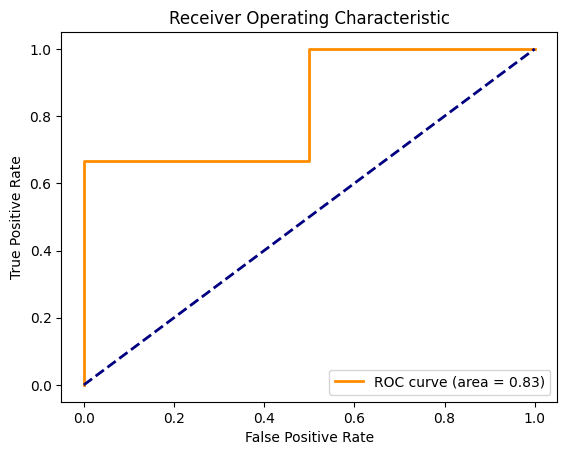

In [86]:
from sklearn.metrics import auc


Y = df_small["Survived"]
Y_pred = df_small["Pred"]


def get_classification_report(Y, Y_pred, threshold=0.1):
    Y_pred_binary = Y_pred > threshold
    print(classification_report(Y, Y_pred_binary))
    
    
    print("Accuracy: ", accuracy_score(Y, Y_pred_binary))
    print("Precision: ", precision_score(Y, Y_pred_binary))
    print("Recall: ", recall_score(Y, Y_pred_binary))
    print("F1: ", f1_score(Y, Y_pred_binary))
    print(roc_auc_score(Y, Y_pred))
    
    
# get roc curve
fpr, tpr, thresholds = roc_curve(Y, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




In [73]:
get_classification_report(Y, Y_pred)

              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy:  0.4
Precision:  0.0
Recall:  0.0
F1:  0.0
0.6666666666666666


c:\Users\hayk_\.conda\envs\dst\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hayk_\.conda\envs\dst\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hayk_\.conda\envs\dst\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hayk_\.conda\envs\dst\lib\si

In [459]:
px.histogram(df["Pred"])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=Pred<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Pred',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'Pred',
              'offsetgroup': 'Pred',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.01823597e-60, 0.00000000e+00, 0.00000000e+00, ..., 0.00000000e+00,
                          0.00000000e+00, 0.00000000e+00]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [379]:
a = predict(df.iloc1])#[{"D"}]
print(a.pignistic())
print(a["D"])
print(a["S"])


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2673387769.py, line 1)

In [332]:
pd.DataFrame(df.iloc[0]).T.query("Age < 22 and Embarked != 2")


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,1.0,0.271174,1.0,0.0,0.014151,0.0


In [333]:
df.iloc[0]

# check if series satisfies the rule
def check_rule(x, rule):
    x = pd.DataFrame(x).T
    return not x.query(rule).empty


True

In [ ]:
# https://bennycheung.github.io/dempster-shafer-theory-for-classification#-pyds-module